In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
dataset = pd.read_csv(r"C:\Users\ismai\Downloads\archive (14)\Frequency Features\frequencyFeatures.csv")

In [44]:
dataset.columns

Index(['ID', 'Label', 'Timestamp', 'xAcc010Hz', 'xAcc015Hz', 'xAcc020Hz',
       'xAcc025Hz', 'xAcc030Hz', 'xAcc035Hz', 'xAcc040Hz',
       ...
       'snd2275Hz', 'snd2300Hz', 'snd2325Hz', 'snd2350Hz', 'snd2375Hz',
       'snd2400Hz', 'snd2425Hz', 'snd2450Hz', 'snd2475Hz', 'snd2500Hz'],
      dtype='object', length=172)

In [45]:
X_full = dataset.drop(['ID','Label','Timestamp'],axis = 1)
y_full = dataset['Label']

accelerometer_data = dataset.iloc[:, 1:72]
'accelerometer_data = accelerometer_data.drop(Timestamp,axis = 1)'
X_accelerometer = accelerometer_data.drop(['Label','Timestamp'], axis=1)
y_accelerometer = accelerometer_data['Label']


microphone_data = pd.concat([dataset.iloc[:, [1]],dataset.iloc[:, [2]], dataset.iloc[:, 72:]],axis=1)
X_microphone = microphone_data.drop(['Label','Timestamp'], axis=1)
y_microphone = microphone_data['Label']

In [7]:


def train_and_predict_models(
    X,
    y,
    test_size=0.3,
    random_state=42,
    use_pca=False,
    n_pca_components=10
):
    # ---------------------------
    # Train-test split
    # ---------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    pca = None
    if use_pca:
        pca = PCA(n_components=n_pca_components, random_state=random_state)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    predictions = {}
    accuracies = {}
    models = {}

    # ---------------------------
    # Decision Tree
    # ---------------------------
    dt = DecisionTreeClassifier(random_state=random_state)
    dt.fit(X_train, y_train)
    preds = dt.predict(X_test)
    predictions["DecisionTree"] = preds
    accuracies["DecisionTree"] = accuracy_score(y_test, preds)
    models["DecisionTree"] = dt

    # ---------------------------
    # Random Forest
    # ---------------------------
    rf = RandomForestClassifier(random_state=random_state)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    predictions["RandomForest"] = preds
    accuracies["RandomForest"] = accuracy_score(y_test, preds)
    models["RandomForest"] = rf

    # ---------------------------
    # Gradient Boosting
    # ---------------------------
    gb = GradientBoostingClassifier(random_state=random_state)
    gb.fit(X_train, y_train)
    preds = gb.predict(X_test)
    predictions["GradientBoosting"] = preds
    accuracies["GradientBoosting"] = accuracy_score(y_test, preds)
    models["GradientBoosting"] = gb

    # ---------------------------
    # XGBoost (label encoding required)
    # ---------------------------
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)

    xgb = XGBClassifier(
        random_state=random_state,
        eval_metric="logloss",
        use_label_encoder=False
    )
    xgb.fit(X_train, y_train_enc)
    preds = le.inverse_transform(xgb.predict(X_test))
    predictions["XGBoost"] = preds
    accuracies["XGBoost"] = accuracy_score(y_test, preds)
    models["XGBoost"] = xgb

    # ---------------------------
    # CatBoost
    # ---------------------------
    cb = CatBoostClassifier(random_state=random_state, verbose=0)
    cb.fit(X_train, y_train)
    preds = cb.predict(X_test)
    predictions["CatBoost"] = preds
    accuracies["CatBoost"] = accuracy_score(y_test, preds)
    models["CatBoost"] = cb

    # ---------------------------
    # Return everything needed
    # ---------------------------
    return {
        "predictions": predictions,
        "accuracies": accuracies,
        "models": models,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "pca": pca
    }


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_heatmaps(y_test, preds, save_path=None, dpi=300):
    """
    Plots confusion matrix heatmaps for each model using original labels
    and optionally saves the figure.

    Parameters:
        y_test : array-like
            True labels
        preds : dict
            model_name -> predicted labels
        save_path : str or None
            File path to save the figure (e.g., 'confusion_matrices.png')
        dpi : int
            Resolution for saved figure
    """

    # Sorted unique class labels
    class_labels = sorted(set(y_test))

    n_models = len(preds)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))

    if n_models == 1:
        axes = [axes]

    for ax, (model_name, y_pred) in zip(axes, preds.items()):
        cm = confusion_matrix(y_test, y_pred, labels=class_labels)

        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels,
            ax=ax
        )

        ax.set_title(model_name)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    fig.tight_layout()

    # ✅ Save BEFORE show
    if save_path is not None:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")

    plt.show()


In [10]:
results_accelerometer = train_and_predict_models(X, y, use_pca=False)
results_microphone = train_and_predict_models(X_microphone, y_microphone, use_pca=False)
results_full = train_and_predict_models(X_full, y_full, use_pca=False)

C:\Users\ismai\anaconda3\envs\project_clean\lib\site-packages\xgboost\training.py:199: UserWarning: [17:30:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ismai\anaconda3\envs\project_clean\lib\site-packages\xgboost\training.py:199: UserWarning: [17:30:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ismai\anaconda3\envs\project_clean\lib\site-packages\xgboost\training.py:199: UserWarning: [17:31:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


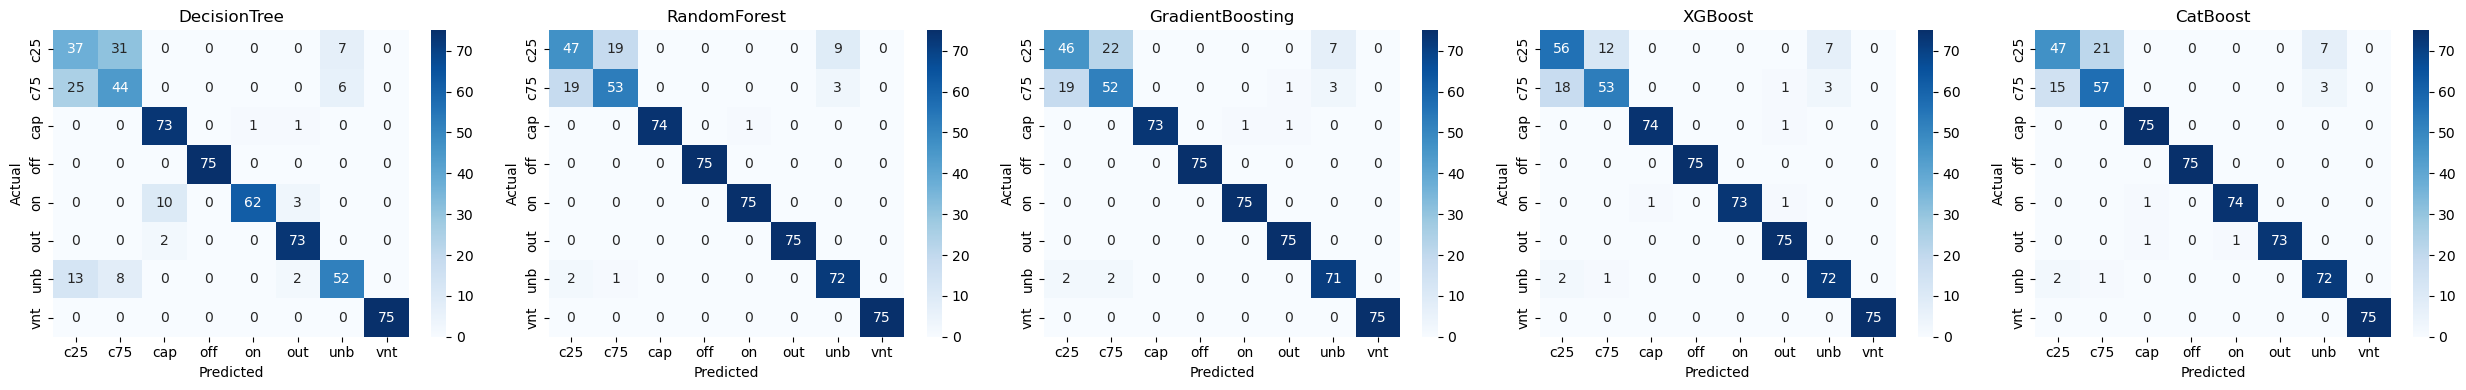

In [37]:
plot_confusion_heatmaps(
    results_accelerometer["y_test"],
    results_accelerometer["predictions"],
    save_path="Accelerometer_confusion_matrices.png"
)



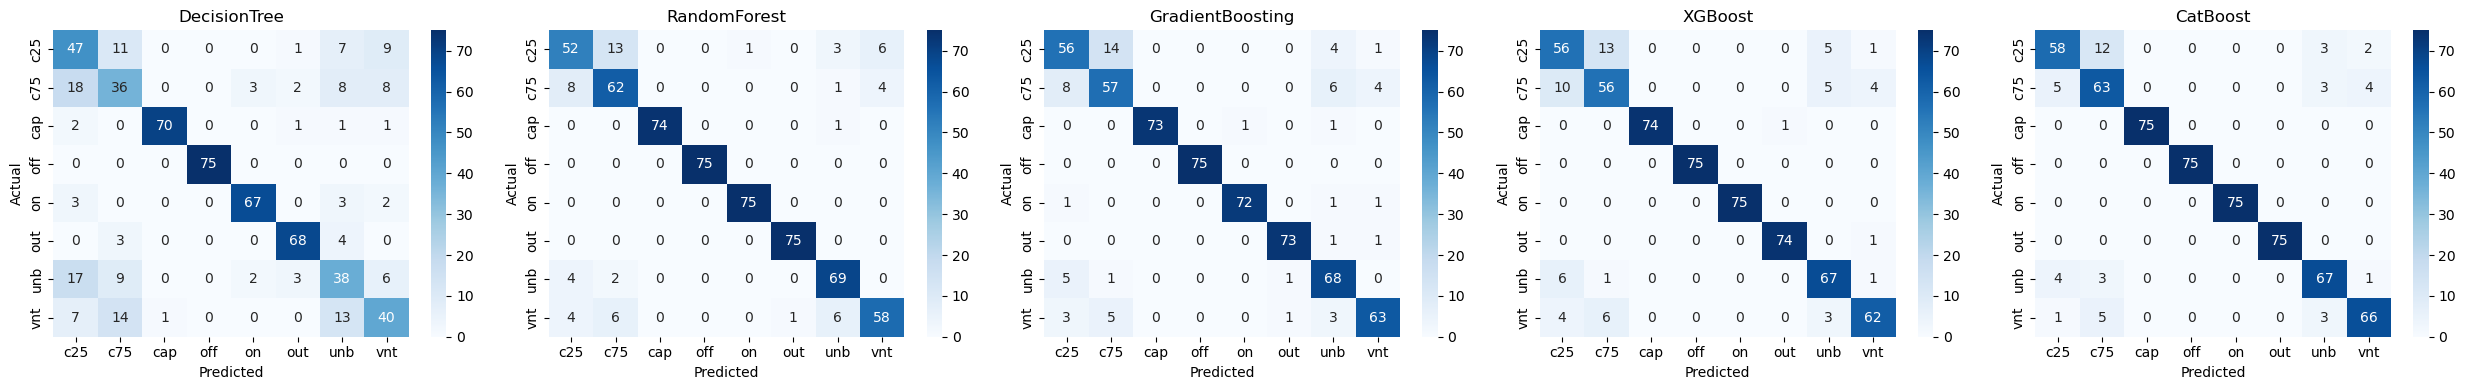

In [38]:
plot_confusion_heatmaps(
    results_microphone["y_test"],
    results_microphone["predictions"],
    save_path="Microphone_confusion_matrices.png"
)

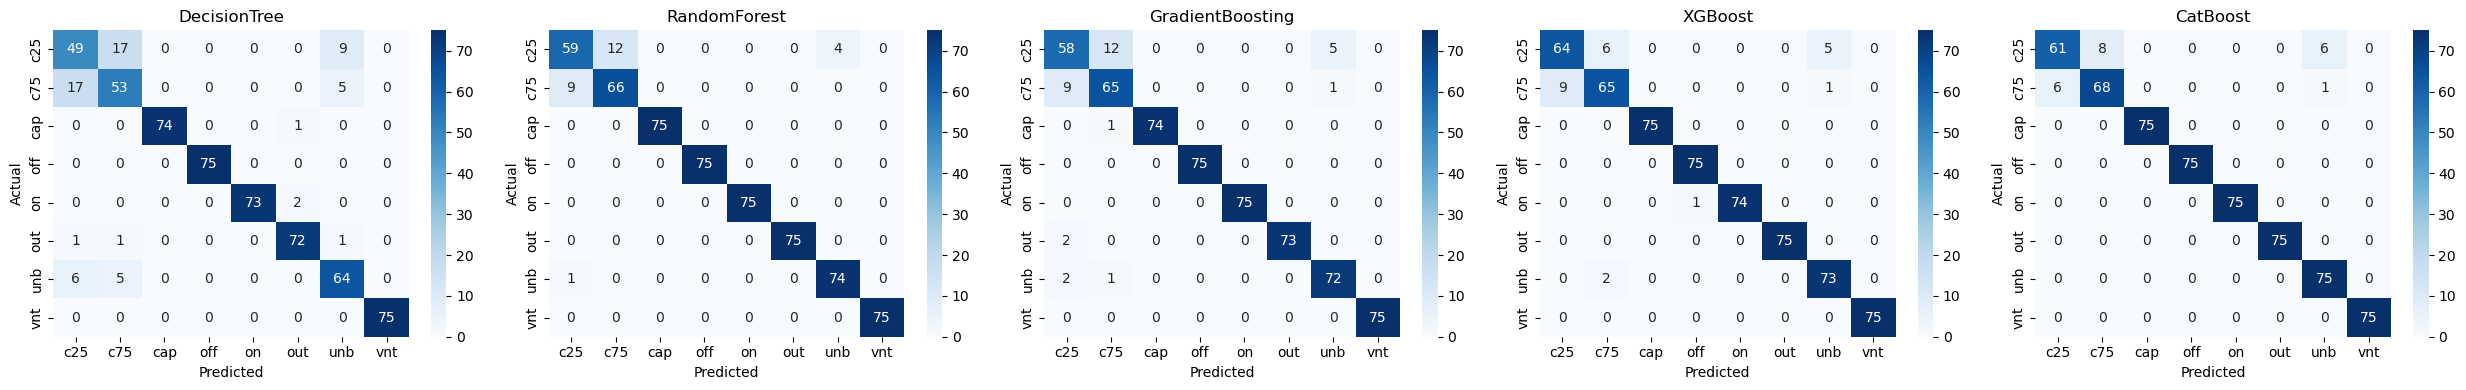

In [39]:
plot_confusion_heatmaps(
    results_full["y_test"],
    results_full["predictions"],
    save_path="full_confusion_matrices.png"
)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.base import clone
import time

def multi_model_sensor_ablation_verbose(results_dataset, model_names=None, top_n=5):
    """
    Perform global sensor ablation across multiple models with verbose progress reporting.
    """
    X_train = results_dataset["X_train"]
    X_test = results_dataset["X_test"]
    y_train = results_dataset["y_train"]
    y_test = results_dataset["y_test"]
    
    if model_names is None:
        model_names = list(results_dataset["models"].keys())
    
    total_sensors = X_train.shape[1]
    sensor_global_scores = {sensor: [] for sensor in X_train.columns}
    
    # Iterate over models
    for model_idx, model_name in enumerate(model_names, 1):
        print(f"\n=== [{model_idx}/{len(model_names)}] Sensor ablation for model: {model_name} ===")
        model = results_dataset["models"][model_name]
        
        # Compute baseline F1 for this model
        baseline_preds = results_dataset["predictions"][model_name]
        baseline_f1 = f1_score(y_test, baseline_preds, average="weighted")
        
        sensor_f1_drop = {}
        start_time_total = time.time()
        
        for idx, sensor in enumerate(X_train.columns, 1):
            start_time = time.time()
            
            # Drop sensor
            X_train_ab = X_train.drop(columns=[sensor])
            X_test_ab = X_test.drop(columns=[sensor])
            
            # Clone model to retrain
            model_clone = clone(model)
            # Special handling for CatBoost
            if model_name == "CatBoost":
                model_clone = CatBoostClassifier(
                    iterations=200, depth=6, learning_rate=0.1, random_state=42, verbose=0
                )
            
            # Train
            model_clone.fit(X_train_ab, y_train)
            y_pred_ab = model_clone.predict(X_test_ab).ravel()
            f1_ab = f1_score(y_test, y_pred_ab, average="weighted")
            
            # Record F1 drop
            sensor_f1_drop[sensor] = baseline_f1 - f1_ab
            
            # Timing info
            elapsed = time.time() - start_time
            sensors_remaining = total_sensors - idx
            est_model_remaining = sensors_remaining * elapsed
            models_remaining = len(model_names) - model_idx
            est_total_remaining = est_model_remaining + models_remaining * total_sensors * elapsed
            
            print(f"[{idx}/{total_sensors}] Sensor: {sensor} | F1 drop: {sensor_f1_drop[sensor]:.4f} "
                  f"| Time: {elapsed:.1f}s | Sensors remaining: {sensors_remaining} "
                  f"| Est. remaining for this model: {est_model_remaining:.1f}s "
                  f"| Total models remaining: {models_remaining} | Est. total remaining time: {est_total_remaining:.1f}s")
        
        # Normalize this model's F1_drop to 0-1
        max_drop = max(sensor_f1_drop.values())
        for sensor in sensor_f1_drop:
            normalized_drop = sensor_f1_drop[sensor] / max_drop if max_drop > 0 else 0
            sensor_global_scores[sensor].append(normalized_drop)
    
    # Compute global importance: mean normalized drop across models
    global_importance = {sensor: np.mean(drops) for sensor, drops in sensor_global_scores.items()}
    global_importance_df = pd.DataFrame.from_dict(global_importance, orient="index", columns=["GlobalScore"])
    global_importance_df = global_importance_df.sort_values("GlobalScore", ascending=False)
    
    # Top sensors
    top_sensors = global_importance_df.head(top_n).index.tolist()
    print("\nTop global sensors across models:", top_sensors)
    
    return global_importance_df, top_sensors


In [14]:
feature_importances = {}

for model_name, model in results_accelerometer["models"].items():
    if model_name in ["DecisionTree", "RandomForest", "GradientBoosting"]:
        importances = model.feature_importances_
    elif model_name == "XGBoost":
        importances_dict = model.get_booster().get_score(importance_type='gain')
        # Ensure order matches X_train columns
        importances = [importances_dict.get(col, 0) for col in results_accelerometer["X_train"].columns]
    elif model_name == "CatBoost":
        importances = model.get_feature_importance(type='PredictionValuesChange')
    
    feature_importances[model_name] = pd.Series(importances, index=results_accelerometer["X_train"].columns).sort_values(ascending=False)

# Print top 5 features for each model
for model_name, series in feature_importances.items():
    print(f"\nTop 5 features for {model_name}:")
    print(series.head(5))

# Find common (intersection) features across all models
top_features_sets = [set(series.head(5).index) for series in feature_importances.values()]
common_features = set.intersection(*top_features_sets)
print("\nCommon top features across models (intersection):", common_features)

# Find union of top features across all models
union_features = set.union(*top_features_sets)
print("Union of top features across models:", union_features)



Top 5 features for DecisionTree:
xAcc025Hz    0.249522
zAcc050Hz    0.155978
xAcc055Hz    0.147566
xAcc045Hz    0.098360
yAcc050Hz    0.097599
dtype: float64

Top 5 features for RandomForest:
xAcc025Hz    0.086803
zAcc045Hz    0.072149
zAcc050Hz    0.065733
yAcc050Hz    0.064074
xAcc020Hz    0.045899
dtype: float64

Top 5 features for GradientBoosting:
xAcc025Hz    0.190003
zAcc050Hz    0.172175
yAcc050Hz    0.113366
xAcc045Hz    0.095487
zAcc085Hz    0.064603
dtype: float64

Top 5 features for XGBoost:
xAcc010Hz    29.106264
xAcc025Hz    10.964964
zAcc050Hz    10.640403
xAcc045Hz     6.297389
yAcc050Hz     5.982945
dtype: float64

Top 5 features for CatBoost:
xAcc025Hz    19.977221
yAcc050Hz    10.468138
zAcc050Hz     8.259947
zAcc045Hz     7.769274
xAcc045Hz     4.937130
dtype: float64

Common top features across models (intersection): {'yAcc050Hz', 'zAcc050Hz', 'xAcc025Hz'}
Union of top features across models: {'yAcc050Hz', 'zAcc085Hz', 'xAcc025Hz', 'zAcc045Hz', 'xAcc055Hz', 'xAcc0

In [12]:
feature_importances = {}

for model_name, model in results_microphone["models"].items():
    if model_name in ["DecisionTree", "RandomForest", "GradientBoosting"]:
        importances = model.feature_importances_
    elif model_name == "XGBoost":
        importances_dict = model.get_booster().get_score(importance_type='gain')
        # Ensure order matches X_train columns
        importances = [importances_dict.get(col, 0) for col in results_microphone["X_train"].columns]
    elif model_name == "CatBoost":
        importances = model.get_feature_importance(type='PredictionValuesChange')
    
    feature_importances[model_name] = pd.Series(importances, index=results_microphone["X_train"].columns).sort_values(ascending=False)

# Print top 5 features for each model
for model_name, series in feature_importances.items():
    print(f"\nTop 5 features for {model_name}:")
    print(series.head(5))

# Find common (intersection) features across all models
top_features_sets = [set(series.head(5).index) for series in feature_importances.values()]
common_features = set.intersection(*top_features_sets)
print("\nCommon top features across models (intersection):", common_features)

# Find union of top features across all models
union_features = set.union(*top_features_sets)
print("Union of top features across models:", union_features)



Top 5 features for DecisionTree:
snd0100Hz    0.267993
snd0725Hz    0.151019
snd0150Hz    0.087247
snd0350Hz    0.036512
snd0075Hz    0.030967
dtype: float64

Top 5 features for RandomForest:
snd0100Hz    0.097056
snd0150Hz    0.060415
snd0350Hz    0.031304
snd0625Hz    0.024766
snd0050Hz    0.021952
dtype: float64

Top 5 features for GradientBoosting:
snd0100Hz    0.265261
snd0150Hz    0.089236
snd0025Hz    0.053578
snd0350Hz    0.048721
snd0075Hz    0.036546
dtype: float64

Top 5 features for XGBoost:
snd0050Hz    24.843025
snd0025Hz    14.520794
snd0100Hz    11.163870
snd0150Hz     6.235524
snd0350Hz     4.552405
dtype: float64

Top 5 features for CatBoost:
snd0100Hz    16.626922
snd0150Hz     8.935083
snd0350Hz     5.514581
snd0950Hz     4.254108
snd0075Hz     3.327809
dtype: float64

Common top features across models (intersection): {'snd0100Hz', 'snd0150Hz', 'snd0350Hz'}
Union of top features across models: {'snd0050Hz', 'snd0100Hz', 'snd0625Hz', 'snd0025Hz', 'snd0150Hz', 'snd07

In [17]:
accelerometer_union = dataset[['Label','yAcc050Hz', 'zAcc045Hz', 'xAcc010Hz', 'xAcc055Hz', 'zAcc085Hz', 'xAcc045Hz', 'zAcc050Hz', 'xAcc025Hz', 'xAcc020Hz']]
X_union = accelerometer_union.drop('Label',axis = 1)
y_union = accelerometer_union['Label']
results_union_accelerometer = train_and_predict_models(X_union,y_union,use_pca=False)

C:\Users\ismai\anaconda3\envs\project_clean\lib\site-packages\xgboost\training.py:199: UserWarning: [17:36:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [16]:
microphone_union = dataset[['Label','snd0150Hz', 'snd0075Hz', 'snd0350Hz', 'snd0625Hz', 'snd0725Hz', 'snd0100Hz', 'snd0050Hz', 'snd0025Hz', 'snd0950Hz']]
X_union_microphone = microphone_union.drop('Label',axis = 1)
y_union_microphone = microphone_union['Label']
results_union_microphone = train_and_predict_models(X_union_microphone,y_union_microphone,use_pca=False)

C:\Users\ismai\anaconda3\envs\project_clean\lib\site-packages\xgboost\training.py:199: UserWarning: [17:35:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [18]:
combined_data = dataset[['Label','yAcc050Hz', 'zAcc045Hz', 'xAcc010Hz', 'xAcc055Hz', 'zAcc085Hz', 'xAcc045Hz', 'zAcc050Hz', 'xAcc025Hz', 'xAcc020Hz','snd0150Hz', 'snd0075Hz', 'snd0350Hz', 'snd0625Hz', 'snd0725Hz', 'snd0100Hz', 'snd0050Hz', 'snd0025Hz', 'snd0950Hz']]

X_combined = combined_data.drop('Label',axis = 1)
y_combined = combined_data['Label']

In [20]:
results_combined = train_and_predict_models(X_combined,y_combined,use_pca=False)

C:\Users\ismai\anaconda3\envs\project_clean\lib\site-packages\xgboost\training.py:199: UserWarning: [17:36:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Class  Microphone data  Accelerometer data  Microphone Union  \
0   c25         0.811189            0.676259          0.517483   
1   c75         0.797468            0.740260          0.607595   
2   cap         1.000000            0.986842          0.959459   
3   off         1.000000            1.000000          1.000000   
4    on         1.000000            0.986667          0.979866   
5   out         1.000000            0.986486          0.973684   
6   unb         0.887417            0.917197          0.675497   
7   vnt         0.891892            1.000000          0.711409   

   Acelerometer union  FULL DATASET  Union combines  
0            0.618421      0.859155        0.695035  
1            0.601399      0.900662        0.738854  
2            0.960526      1.000000        0.993377  
3            1.000000      1.000000        1.000000  
4            0.958904      1.000000        1.000000  
5            0.960526      1.000000        0.986667  
6            0.877419      

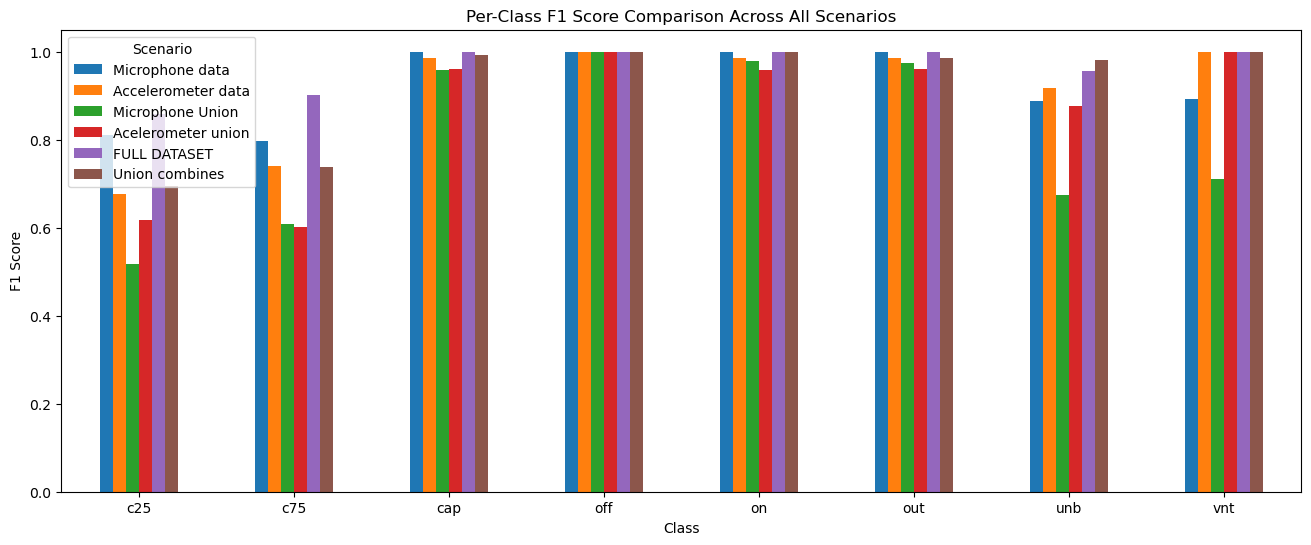

In [22]:
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt

# List of scenarios
scenarios = {
    "Microphone data": results_microphone,
    "Accelerometer data": results_accelerometer,
    "Microphone Union": results_union_microphone,
    "Acelerometer union": results_union_accelerometer,
    "FULL DATASET": results_full,
    "Union combines": results_combined  # Added
}

# True labels (assuming all have same y_test)
y_test = results_microphone["y_test"]
classes = sorted(y_test.unique())

# Prepare DataFrame
per_class_f1 = pd.DataFrame({"Class": classes})

# Compute per-class F1 for each scenario
for name, res in scenarios.items():
    y_pred = res["predictions"]["CatBoost"]  # you can change model here
    f1_scores = f1_score(y_test, y_pred, average=None, labels=classes)
    per_class_f1[name] = f1_scores

print(per_class_f1)

# Optional: plot
per_class_f1_plot = per_class_f1.set_index("Class")
per_class_f1_plot.plot(kind="bar", figsize=(16,6), rot=0)
plt.ylabel("F1 Score")
plt.ylim(0,1.05)
plt.title("Per-Class F1 Score Comparison Across All Scenarios")
plt.legend(title="Scenario")
plt.show()


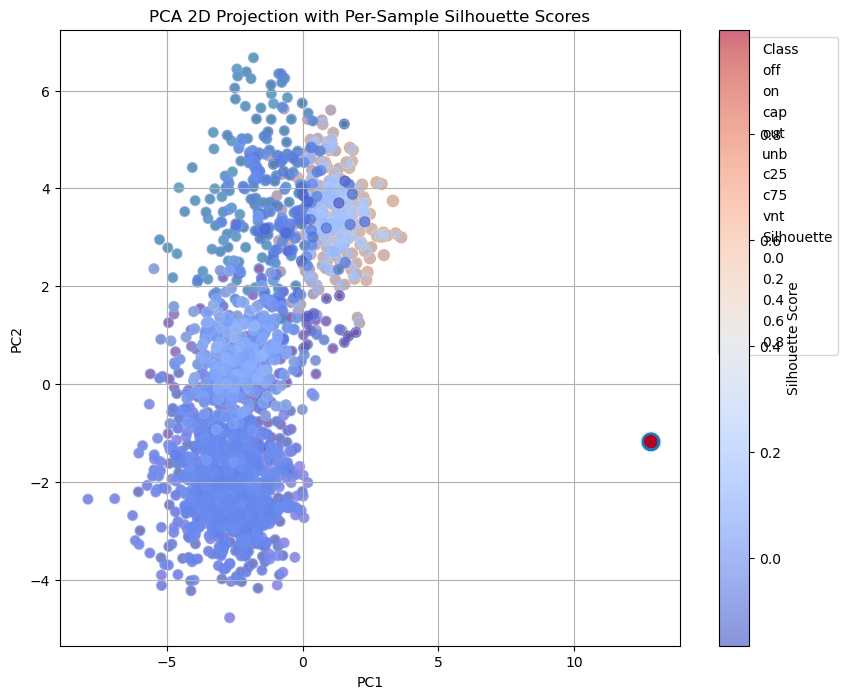

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples
import pandas as pd
import numpy as np

# -----------------------------
# Standardize features
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# PCA 2D projection
# -----------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# -----------------------------
# Compute per-sample silhouette scores
# -----------------------------
# Use Euclidean distance and the labels
silhouette_vals = silhouette_samples(X_scaled, y, metric='euclidean')

# -----------------------------
# Prepare DataFrame for plotting
# -----------------------------
plot_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Class': y,
    'Silhouette': silhouette_vals
})

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=plot_df, 
    x='PC1', y='PC2', 
    hue='Class', 
    size='Silhouette',  # optionally scale by silhouette
    palette='tab10', 
    sizes=(20, 200),
    alpha=0.8
)

# Use a colorbar to show silhouette score if desired
scatter = plt.scatter(
    plot_df['PC1'], plot_df['PC2'], c=plot_df['Silhouette'],
    cmap='coolwarm', s=50, alpha=0.6
)
plt.colorbar(scatter, label='Silhouette Score')

plt.title("PCA 2D Projection with Per-Sample Silhouette Scores")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


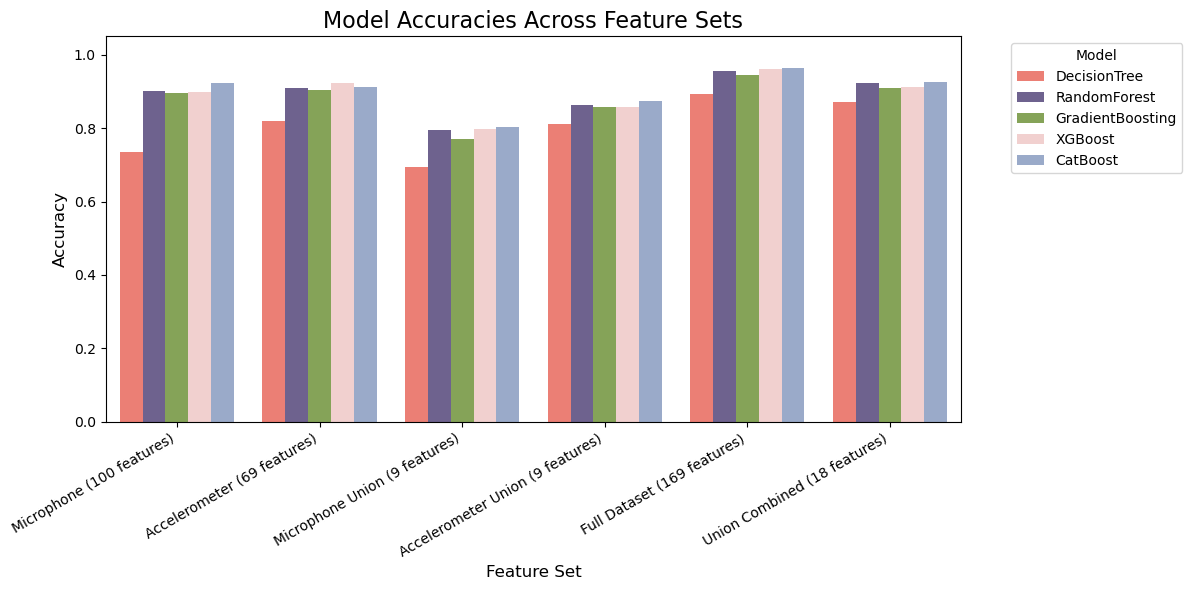

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Feature sets and results
feature_sets = {
    "Microphone (100 features)": results_microphone,
    "Accelerometer (69 features)": results_accelerometer,
    "Microphone Union (9 features)": results_union_microphone,
    "Accelerometer Union (9 features)": results_union,
    "Full Dataset (169 features)": results_full,
    "Union Combined (18 features)": results_combined
}

models = ["DecisionTree", "RandomForest", "GradientBoosting", "XGBoost", "CatBoost"]

# Prepare DataFrame in long format for Seaborn
data = []
for fs_name, fs_results in feature_sets.items():
    for model_name in models:
        data.append({
            "Feature Set": fs_name,
            "Model": model_name,
            "Accuracy": fs_results["accuracies"][model_name]
        })

df_plot = pd.DataFrame(data)

# Custom visually appealing palette
custom_palette = {
    "DecisionTree": "#FF6F61",      # coral
    "RandomForest": "#6B5B95",      # purple
    "GradientBoosting": "#88B04B",  # green
    "XGBoost": "#F7CAC9",           # soft pink
    "CatBoost": "#92A8D1"           # soft blue
}

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_plot,
    x="Feature Set",
    y="Accuracy",
    hue="Model",
    palette=custom_palette
)

plt.title("Model Accuracies Across Feature Sets", fontsize=16)
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1.05)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Feature Set", fontsize=12)

# Legend outside
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()

plt.savefig(
    "model_accuracies_across_feature_sets.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


In [29]:
# Save the figure
plt.savefig(
    "model_accuracies_across_feature_sets.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


<Figure size 640x480 with 0 Axes>

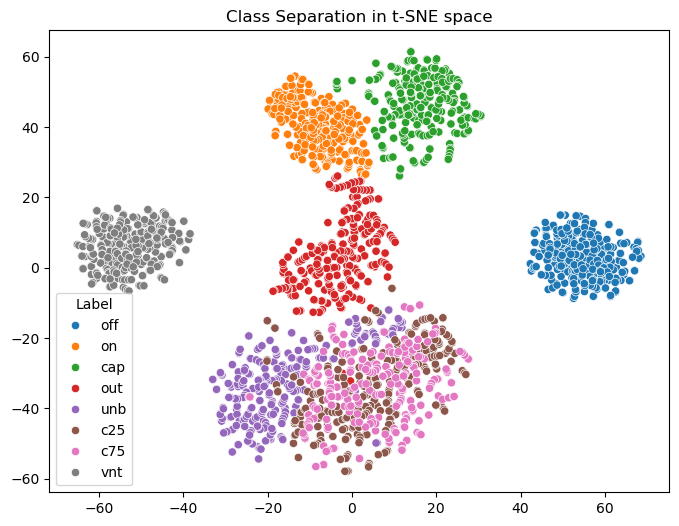

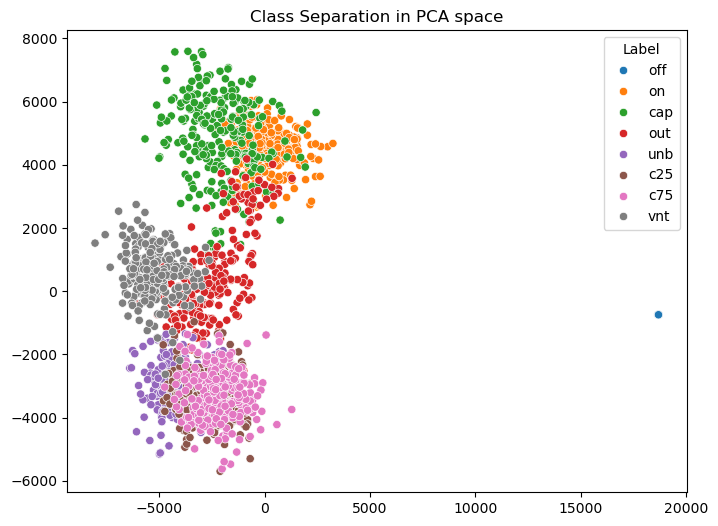

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y)
plt.title("Class Separation in t-SNE space")
plt.show()

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title("Class Separation in PCA space")
plt.show()


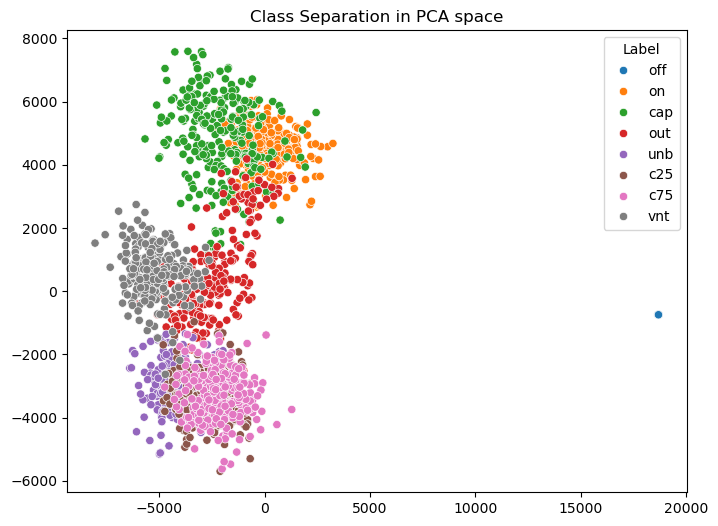

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title("Class Separation in PCA space")

plt.savefig(
    "PCA_Space_plot.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

  Class  Microphone data(100 fetaures)  Accelerometer data(69 fetaures)  \
0   c25                       0.756757                         0.647887   
1   c75                       0.750000                         0.688742   
2   cap                       0.986486                         0.986486   
3   off                       1.000000                         1.000000   
4    on                       0.972973                         0.993377   
5   out                       0.973333                         0.986842   
6   unb                       0.855346                         0.910256   
7   vnt                       0.868966                         1.000000   

   Microphone Union(9 fetaures)  Acelerometer union(9 fetaures)  \
0                      0.480519                        0.601307   
1                      0.541935                        0.539007   
2                      0.979866                        0.935897   
3                      1.000000                        1

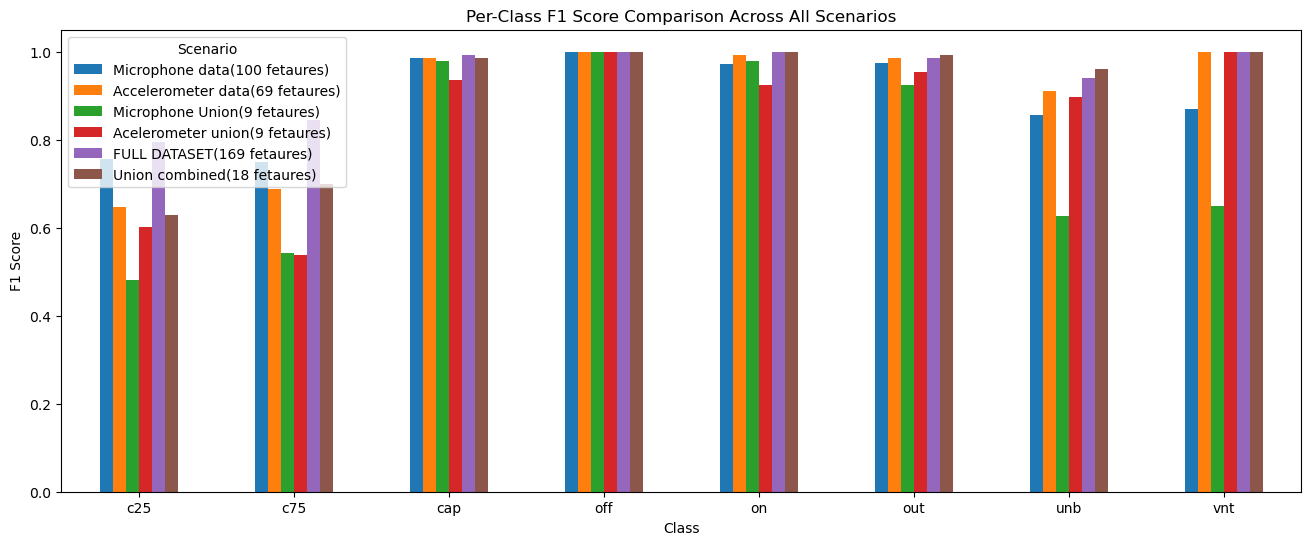

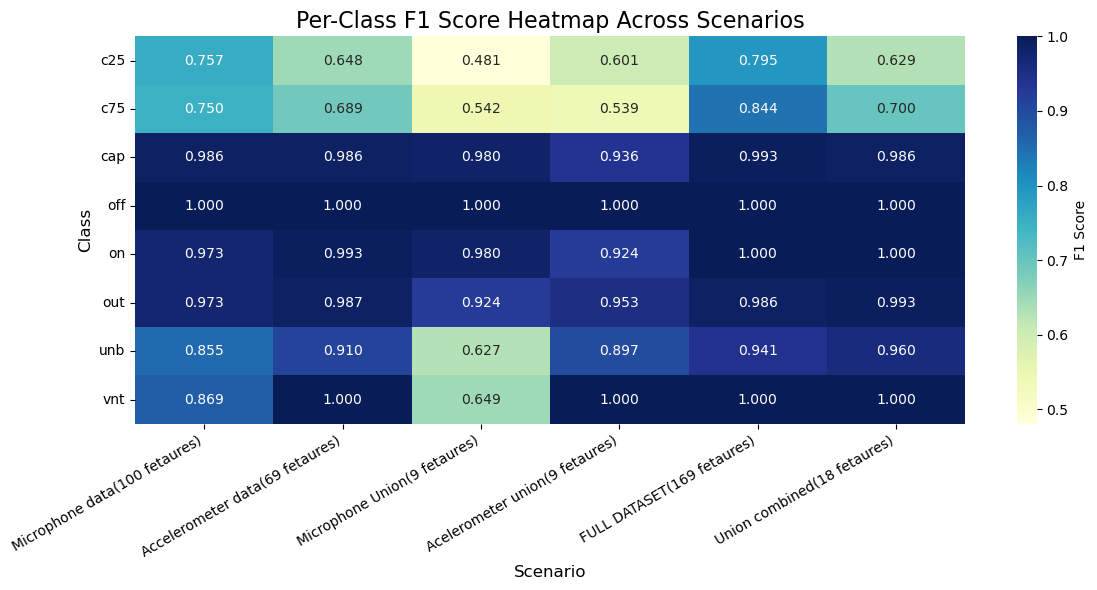

In [28]:
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt

# List of scenarios
scenarios = {
    "Microphone data(100 fetaures)": results_microphone,
    "Accelerometer data(69 fetaures)": results_accelerometer,
    "Microphone Union(9 fetaures)": results_union_microphone,
    "Acelerometer union(9 fetaures)": results_union,
    "FULL DATASET(169 fetaures)": results_full,
    "Union combined(18 fetaures)": results_combined  # Added
}

# True labels (assuming all have same y_test)
y_test = results_microphone["y_test"]
classes = sorted(y_test.unique())

# Prepare DataFrame
per_class_f1 = pd.DataFrame({"Class": classes})

# Compute per-class F1 for each scenario
for name, res in scenarios.items():
    y_pred = res["predictions"]["GradientBoosting"]  # you can change model here
    f1_scores = f1_score(y_test, y_pred, average=None, labels=classes)
    per_class_f1[name] = f1_scores

print(per_class_f1)

# Optional: plot
per_class_f1_plot = per_class_f1.set_index("Class")
per_class_f1_plot.plot(kind="bar", figsize=(16,6), rot=0)
plt.ylabel("F1 Score")
plt.ylim(0,1.05)
plt.title("Per-Class F1 Score Comparison Across All Scenarios")
plt.legend(title="Scenario")
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Set index to 'Class' for heatmap
per_class_f1_heatmap = per_class_f1.set_index("Class")

plt.figure(figsize=(12,6))
sns.heatmap(
    per_class_f1_heatmap, 
    annot=True,            # show numbers
    fmt=".3f",             # 3 decimal places
    cmap="YlGnBu",         # visually appealing color map
    cbar_kws={'label': 'F1 Score'}
)

plt.title("Per-Class F1 Score Heatmap Across Scenarios", fontsize=16)
plt.ylabel("Class", fontsize=12)
plt.xlabel("Scenario", fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
'snd0100Hz', 'snd0150Hz', 'snd0350Hz'

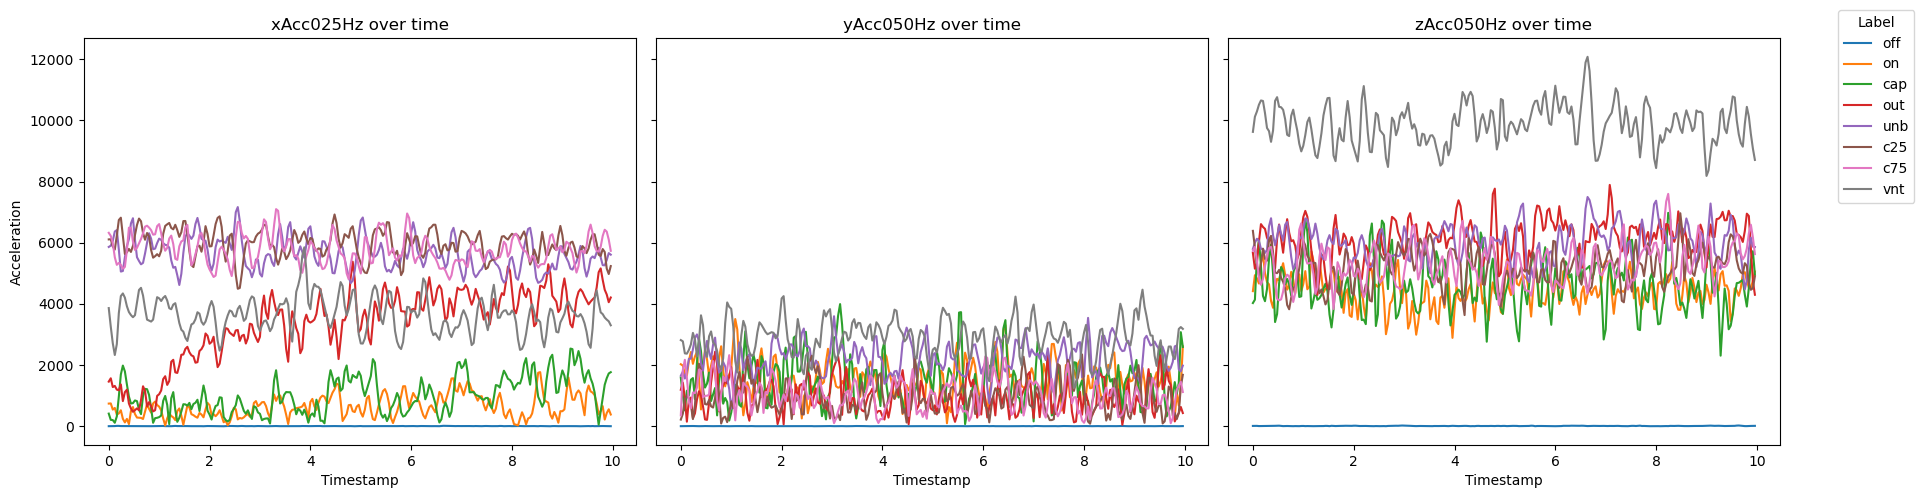

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

sensors = ['xAcc025Hz', 'yAcc050Hz', 'zAcc050Hz']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, sensor in zip(axes, sensors):
    sns.lineplot(
        x='Timestamp',
        y=sensor,
        hue='Label',
        data=accelerometer_data,
        ax=ax
    )
    ax.set_title(f"{sensor} over time")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Acceleration")

# Put legend only once (outside)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Label", bbox_to_anchor=(1.02, 1), loc="upper left")

# Remove duplicate legends
for ax in axes:
    ax.get_legend().remove()

fig.tight_layout()
plt.show()


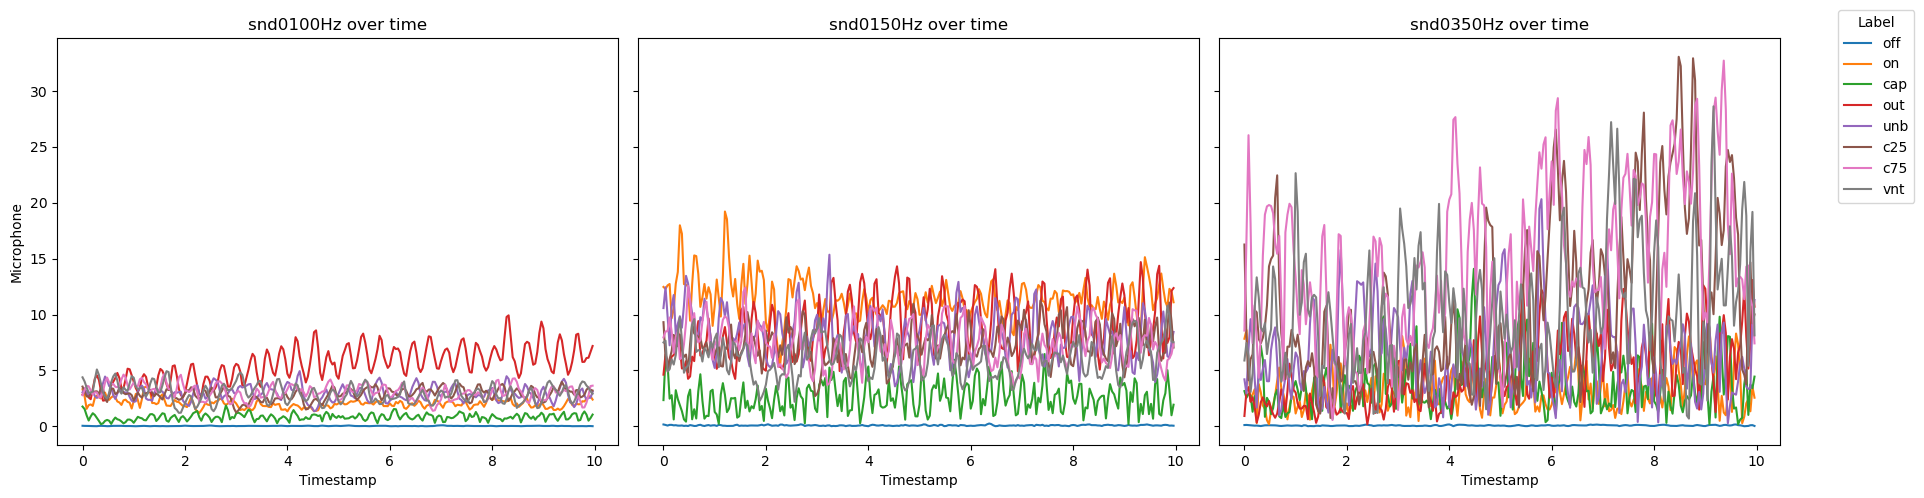

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sensors = ['snd0100Hz', 'snd0150Hz', 'snd0350Hz']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, sensor in zip(axes, sensors):
    sns.lineplot(
        x='Timestamp',
        y=sensor,
        hue='Label',
        data=microphone_data,
        ax=ax
    )
    ax.set_title(f"{sensor} over time")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Microphone")

# Put legend only once (outside)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Label", bbox_to_anchor=(1.02, 1), loc="upper left")

# Remove duplicate legends
for ax in axes:
    ax.get_legend().remove()

fig.tight_layout()
plt.show()

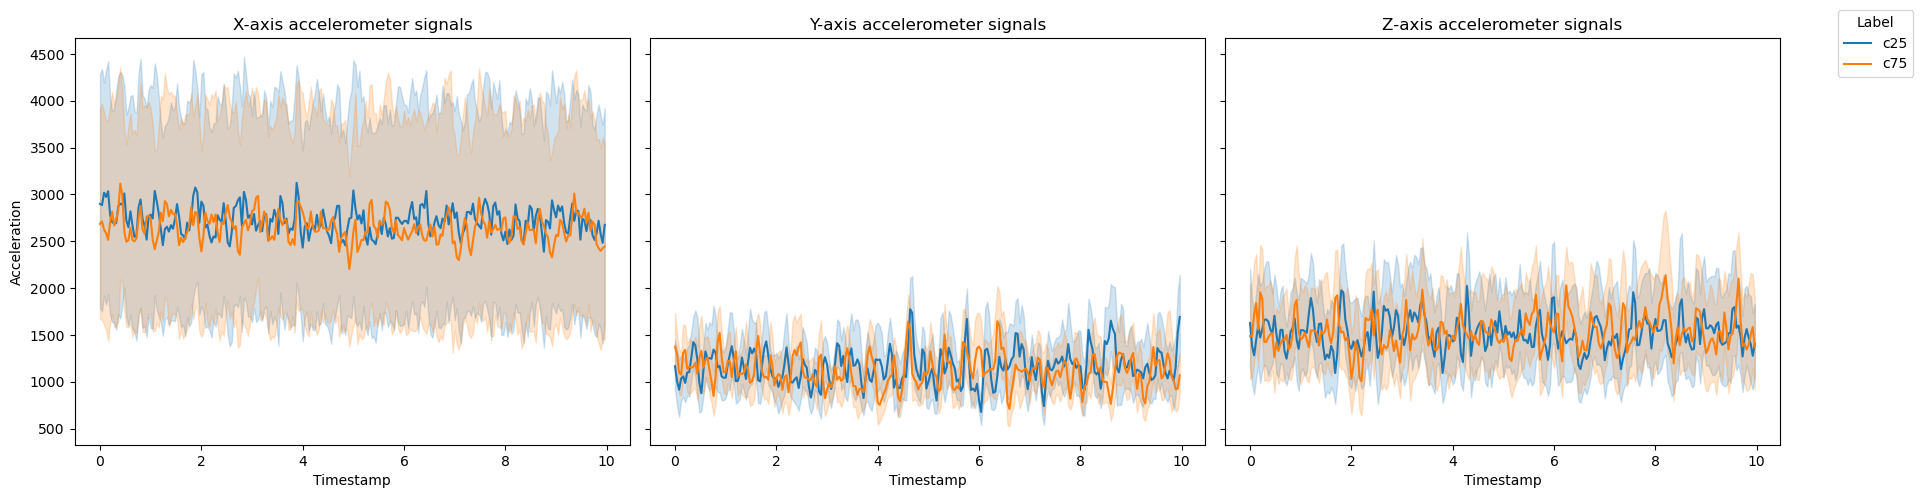

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only the rows for c25 and c75
df_subset = accelerometer_data[accelerometer_data['Label'].isin(['c25', 'c75'])]

# Separate axis columns
x_cols = [col for col in df_subset.columns if col.startswith('xAcc')]
y_cols = [col for col in df_subset.columns if col.startswith('yAcc')]
z_cols = [col for col in df_subset.columns if col.startswith('zAcc')]

axes_dict = {'X-axis': x_cols, 'Y-axis': y_cols, 'Z-axis': z_cols}

# Create line plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, (axis_name, cols) in zip(axes, axes_dict.items()):
    # Melt dataframe for Seaborn
    df_melt = df_subset.melt(id_vars=['Timestamp', 'Label'], value_vars=cols,
                             var_name='Sensor', value_name='Acceleration')
    
    sns.lineplot(data=df_melt, x='Timestamp', y='Acceleration', hue='Label', ax=ax)
    ax.set_title(f"{axis_name} accelerometer signals")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Acceleration")
    ax.legend().remove()  # Remove legend from individual plots

# Add one legend outside the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Label", bbox_to_anchor=(1.02, 1), loc="upper left")

fig.tight_layout()
plt.show()


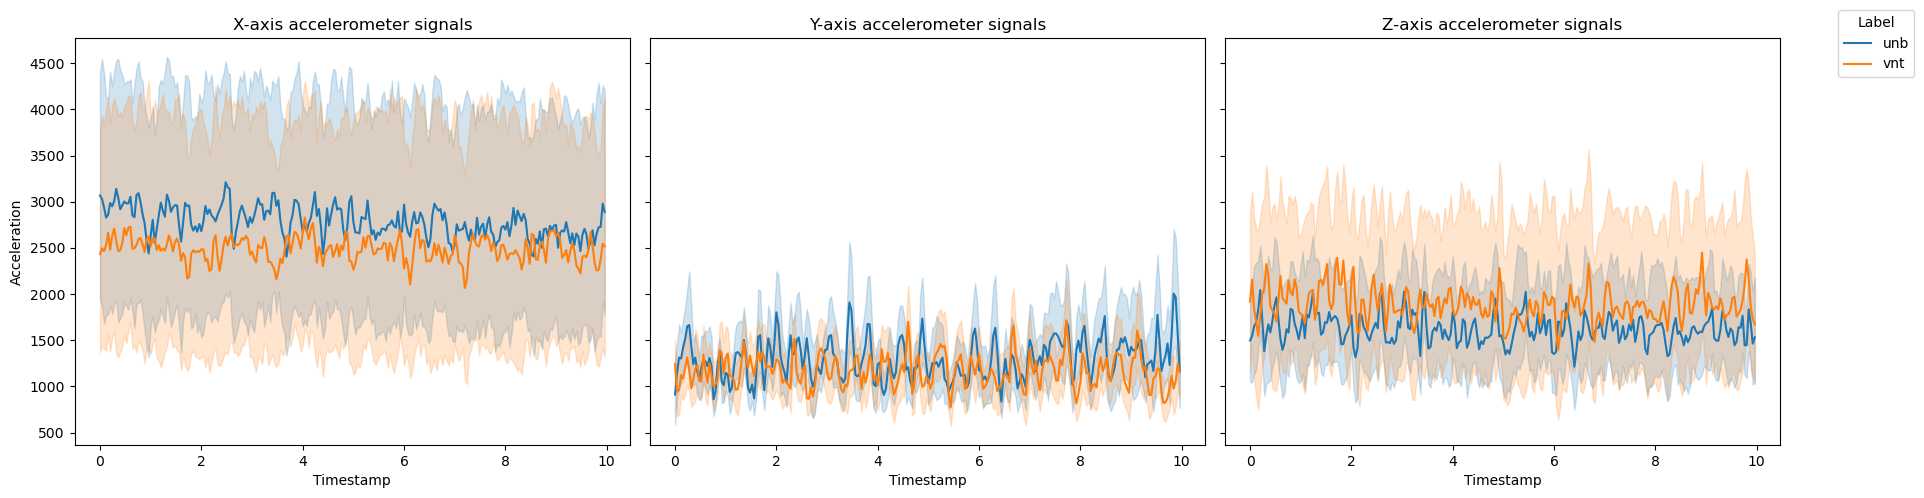

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only the rows for c25 and c75
df_subset = accelerometer_data[accelerometer_data['Label'].isin(['unb', 'vnt'])]

# Separate axis columns
x_cols = [col for col in df_subset.columns if col.startswith('xAcc')]
y_cols = [col for col in df_subset.columns if col.startswith('yAcc')]
z_cols = [col for col in df_subset.columns if col.startswith('zAcc')]

axes_dict = {'X-axis': x_cols, 'Y-axis': y_cols, 'Z-axis': z_cols}

# Create line plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, (axis_name, cols) in zip(axes, axes_dict.items()):
    # Melt dataframe for Seaborn
    df_melt = df_subset.melt(id_vars=['Timestamp', 'Label'], value_vars=cols,
                             var_name='Sensor', value_name='Acceleration')
    
    sns.lineplot(data=df_melt, x='Timestamp', y='Acceleration', hue='Label', ax=ax)
    ax.set_title(f"{axis_name} accelerometer signals")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Acceleration")
    ax.legend().remove()  # Remove legend from individual plots

# Add one legend outside the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Label", bbox_to_anchor=(1.02, 1), loc="upper left")

fig.tight_layout()
plt.show()


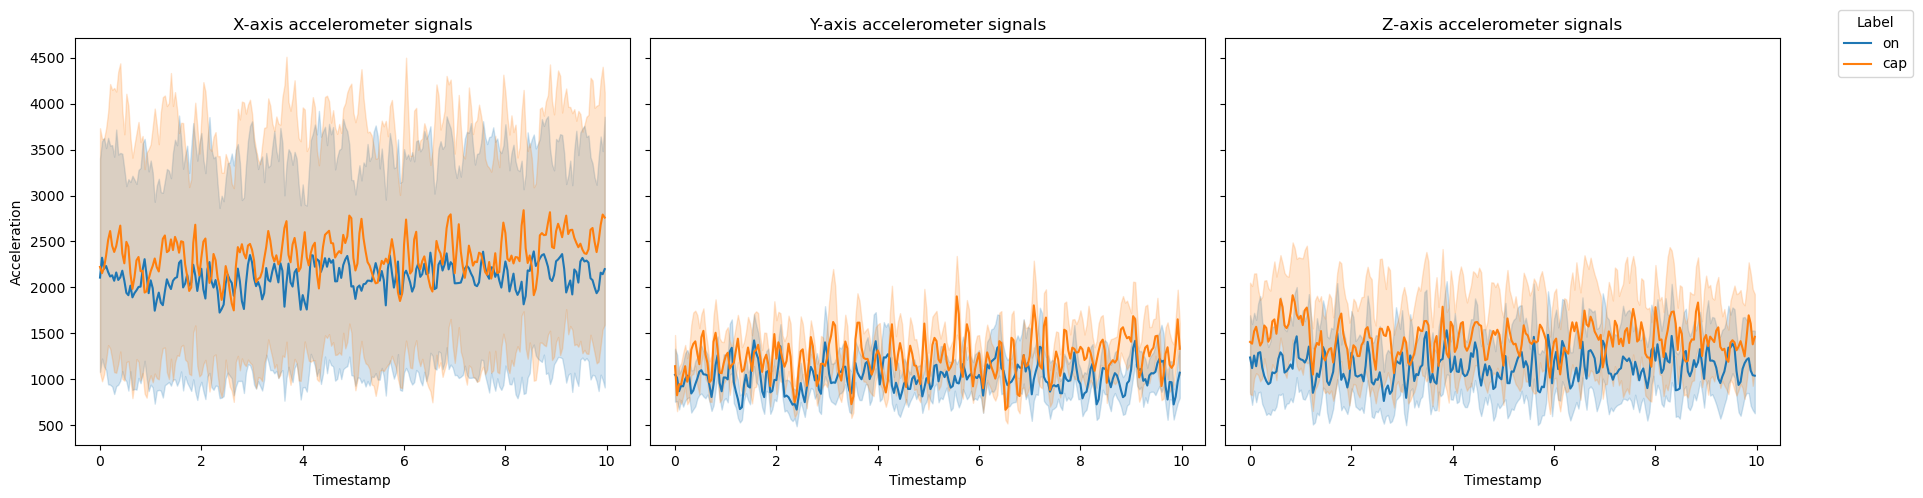

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only the rows for c25 and c75
df_subset = accelerometer_data[accelerometer_data['Label'].isin(['on', 'cap'])]

# Separate axis columns
x_cols = [col for col in df_subset.columns if col.startswith('xAcc')]
y_cols = [col for col in df_subset.columns if col.startswith('yAcc')]
z_cols = [col for col in df_subset.columns if col.startswith('zAcc')]

axes_dict = {'X-axis': x_cols, 'Y-axis': y_cols, 'Z-axis': z_cols}

# Create line plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, (axis_name, cols) in zip(axes, axes_dict.items()):
    # Melt dataframe for Seaborn
    df_melt = df_subset.melt(id_vars=['Timestamp', 'Label'], value_vars=cols,
                             var_name='Sensor', value_name='Acceleration')
    
    sns.lineplot(data=df_melt, x='Timestamp', y='Acceleration', hue='Label', ax=ax)
    ax.set_title(f"{axis_name} accelerometer signals")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Acceleration")
    ax.legend().remove()  # Remove legend from individual plots

# Add one legend outside the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Label", bbox_to_anchor=(1.02, 1), loc="upper left")

fig.tight_layout()
plt.show()
